# Exam Part 2 Notebook

*Authors*: Matias Piqueras, Sebastian Hørlück


This notebook contains the code used to generate the results included in the final exam. The notebook can be run as long as the dataset `cross_section.csv` and `panel.csv` and the python files `exam.py` and `exam_utils.py` are in the same directory. Some text is reused from the `getting_started.ipynb`.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from IPython.display import set_matplotlib_formats
plt.style.use('science')
set_matplotlib_formats('svg')
import seaborn as sns
from exam import Part1Estimator, Part2Estimator
from exam_utils import calc_r2, partial_effects, wald_test
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_120303/3875008187.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Cross-sectional dataset

This dataset just has the variables, `y`, `x1` (the constant), `x2` (the binary variable), and `x3` (the continuous variable). 

In [2]:
#Read in the data
cs = pd.read_csv('cross_section.csv')
# convert to numpy arrays 
y = cs['y'].values
x = cs[['x1', 'x2', 'x3']].values
N,K = x.shape

In [3]:
#Instaniate model object and fit data
exp_model = Part1Estimator(estimator='exp').fit(y, x, cov_type='Hessian')
norm_model = Part1Estimator(estimator='norm').fit(y, x, cov_type='Hessian')

Optimization terminated successfully.
         Current function value: 1.434272
         Iterations: 21
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 1.438699
         Iterations: 20
         Function evaluations: 180
         Gradient evaluations: 36


In [4]:
#Show results
labels = ['x1', 'x2', 'x3', 'sigma_u']
exp_model.summary(theta_label=labels)

Optimizer succeded after 21 iter. (130 func. evals.). Final criterion:    1.434.
Results


,theta,se,t
x1,-1.0229,0.0376,-27.1836
x2,1.0371,0.0712,14.5647
x3,0.8234,0.0812,10.1368
sigma_u,1.0155,0.0227,44.7202


In [5]:
norm_model.summary(theta_label=labels)

Optimizer succeded after 20 iter. (180 func. evals.). Final criterion:    1.439.
Results


,theta,se,t
x1,0.9192,0.0796,11.5508
x2,-1.1848,0.0739,-16.0324
x3,-1.1459,0.1254,-9.1395
sigma_u,1.0200,0.0228,44.7202


Below we calculate the predictions, $R^2$ and residuals

In [6]:
#Calc predictions
cs['norm_pred'] = norm_model.predict(x)
cs['exp_pred'] = exp_model.predict(x)
#Calc R^2
norm_r2 = calc_r2(cs['y'], cs['norm_pred'])
exp_r2 = calc_r2(cs['y'], cs['exp_pred'])

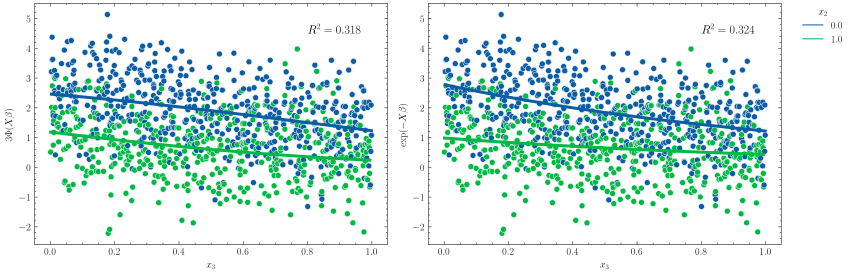

In [7]:
#Sort values by x3 and plot the predictions vs. obs
cs = cs.sort_values('x3')
fig, axs = plt.subplots(ncols = 2, figsize=(12,4), dpi = 300)
sns.scatterplot(y = 'y', x = 'x3', hue = 'x2', data = cs, ax = axs[0], legend=False)
axs[0].set_ylabel('$3\\Phi(X\mathbf{\\beta)}$')
axs[0].text(0.8, 4.5, f'$R^2 = {np.round(norm_r2,3)}$', fontsize = 12)
sns.lineplot(y = 'norm_pred', x = 'x3', hue = 'x2', data = cs, ax = axs[0],  linewidth = 3, legend = False)
sns.scatterplot(y = 'y', x = 'x3', hue = 'x2', data = cs, ax = axs[1], legend=False)
axs[0].set_xlabel('$x_3$')
axs[1].set_ylabel('$\\exp(-X\mathbf{\\beta)}$')
sns.lineplot(y = 'exp_pred', x = 'x3', hue = 'x2', data = cs, ax = axs[1], linewidth = 3, legend=True)
axs[1].text(0.8, 4.5, f'$R^2 = {np.round(exp_r2,3)}$', fontsize = 12)
axs[1].set_xlabel('$x_3$')
axs[1].legend(title="$x_2$",bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('fit.pdf')

### Partial Effects

Here we calculate the partial effects given by

$$\delta_j(x^0) = -\exp(-x^0\beta)\beta_j$$

In [8]:
#Define x0
x1 = np.ones(11).reshape(-1,1)
x2 = np.ones(11).reshape(-1,1)
x3 = np.linspace(0,1, 11).reshape(-1,1)
x0 = np.hstack([x1,x2,x3])

#Model and its derivate w.r.t. x
model = Part1Estimator(estimator='exp', estimate_sigma=False)
deriv = lambda x,beta: -np.exp(-x@beta).reshape(-1,1)*beta

#Get pe and their se from 2500 bootstrap its
pe, pe_se = partial_effects(model,y,x,deriv,x0, N_bootstraps=2500)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [9]:
#Show results
print(pd.DataFrame(np.hstack([pe, pe_se]), index = x3.flatten(), 
             columns=['pe_b1','pe_b2', 'pe_b3', 
                      'se_pe_b1', 'se_pe_b2', 'se_pe_b3']).round(4).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &   pe\_b1 &   pe\_b2 &   pe\_b3 &  se\_pe\_b1 &  se\_pe\_b2 &  se\_pe\_b3 \\
\midrule
0.0 &  1.0086 & -1.0225 & -0.8119 &    0.0950 &    0.0382 &    0.1188 \\
0.1 &  0.9289 & -0.9417 & -0.7477 &    0.0829 &    0.0295 &    0.1040 \\
0.2 &  0.8554 & -0.8673 & -0.6886 &    0.0725 &    0.0229 &    0.0909 \\
0.3 &  0.7878 & -0.7987 & -0.6342 &    0.0636 &    0.0186 &    0.0793 \\
0.4 &  0.7255 & -0.7356 & -0.5840 &    0.0562 &    0.0166 &    0.0691 \\
0.5 &  0.6682 & -0.6774 & -0.5379 &    0.0500 &    0.0167 &    0.0602 \\
0.6 &  0.6154 & -0.6239 & -0.4954 &    0.0450 &    0.0180 &    0.0523 \\
0.7 &  0.5667 & -0.5746 & -0.4562 &    0.0409 &    0.0198 &    0.0454 \\
0.8 &  0.5219 & -0.5291 & -0.4201 &    0.0377 &    0.0216 &    0.0394 \\
0.9 &  0.4807 & -0.4873 & -0.3869 &    0.0351 &    0.0232 &    0.0343 \\
1.0 &  0.4427 & -0.4488 & -0.3564 &    0.0331 &    0.0246 &    0.0298 \\
\bottomrule
\end{tabular}



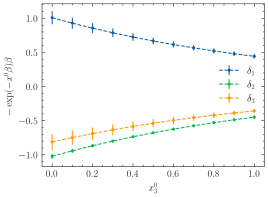

In [10]:
#Plot results
fig, ax = plt.subplots(dpi = 300, figsize=(4,3))
#ax.plot(x0[:,2], beta_ests[:,0], 'o--', label='$\\beta_1$')
ax.errorbar(x0[:,2], pe[:,0], yerr=pe_se[:,0], fmt='o--', label='$\\delta_1$', markersize=2, linewidth=1)
ax.errorbar(x0[:,2], pe[:,1], yerr=pe_se[:,1], fmt='o--', label='$\\delta_2$', markersize=2, linewidth=1)
ax.errorbar(x0[:,2], pe[:,2], yerr=pe_se[:,2], fmt='o--', label='$\\delta_3$', markersize=2, linewidth=1)
ax.set_xlabel('$x^0_3$')
ax.set_ylabel('$-\\exp(-x^0\\beta)\\beta$')
ax.legend()
plt.savefig('partials.pdf')

# Panel dataset

This dataset contains $N=100$ individuals observed for $T = 10$ periods. In addition to the variables `y`, `x1`, `x2`, `x3`, this dataset also contains the variable `i` (denoting individuals), and `t` (denoting time). You do not need to use `i` and `t` in your code; it is included to help make clear the panel structure and the sorting of the dataset.  

In [11]:
p = pd.read_csv('panel.csv')
N = p['i'].nunique() # no. unique values of personal identifier 
T = p['t'].nunique() # no. unique values of tim 
x_vars = ['x1', 'x2', 'x3']
K = len(x_vars)

# extract as numpy objects 
y = p['y'].values.reshape(N,T) # (N,T) array 
x = p[x_vars].values.reshape(N,T,K) # (N,T,K) array 

In [12]:
exp_panel_model = Part2Estimator(estimator='exp', R=500).fit(y,x, cov_type='Hessian')
norm_panel_model = Part2Estimator(estimator='norm', R=500).fit(y,x, cov_type='Hessian')

Optimization terminated successfully.
         Current function value: 8.912037
         Iterations: 17
         Function evaluations: 180
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 10.542929
         Iterations: 24
         Function evaluations: 210
         Gradient evaluations: 35


In [13]:
labels = x_vars + ['sigma_e', 'sigma_c']
norm_panel_model.summary(labels)

Optimizer succeded after 24 iter. (210 func. evals.). Final criterion:    10.54.
Results


,theta,se,t
x1,0.7877,0.0731,10.7694
x2,-1.0959,0.0501,-21.8791
x3,-1.1808,0.0794,-14.8694
sigma_e,-0.5850,0.0137,-42.5622
sigma_c,0.5513,0.0478,11.5430


In [14]:
labels = x_vars + ['sigma_e', 'sigma_c']
exp_panel_model.summary(labels)

Optimizer succeded after 17 iter. (180 func. evals.). Final criterion:    8.912.
Results


,theta,se,t
x1,-0.9154,0.0510,-17.9516
x2,0.8848,0.0297,29.7861
x3,0.8907,0.0405,21.9954
sigma_e,-0.5149,0.0121,-42.4666
sigma_c,0.4603,0.0373,12.3502


In [15]:
#Calc predictions
p['norm_pred'] = norm_panel_model.predict(x).reshape(N*T)
p['exp_pred'] = exp_panel_model.predict(x).reshape(N*T)
#Calc R^2
norm_r2 = calc_r2(p['y'], p['norm_pred'])
exp_r2 = calc_r2(p['y'], p['exp_pred'])

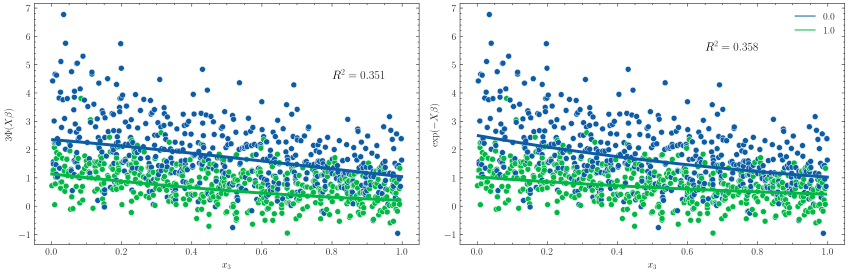

In [16]:
#Plot the predictions
#Sort values by x3 and plot the predictions vs. obs
p = p.sort_values('x3')
fig, axs = plt.subplots(ncols = 2, figsize=(12,4), dpi = 300)
sns.scatterplot(y = 'y', x = 'x3', hue = 'x2', data = p, ax = axs[0], legend=False)
axs[0].set_ylabel('$3\\Phi(X\mathbf{\\beta)}$')
axs[0].text(0.8, 4.5, f'$R^2 = {np.round(norm_r2,3)}$', fontsize = 12)
sns.lineplot(y = 'norm_pred', x = 'x3', hue = 'x2', data = p, ax = axs[0],  linewidth = 3, legend = False)
sns.scatterplot(y = 'y', x = 'x3', hue = 'x2', data = p, ax = axs[1], legend=False)
axs[0].set_xlabel('$x_3$')
axs[1].set_ylabel('$\\exp(-X\mathbf{\\beta)}$')
sns.lineplot(y = 'exp_pred', x = 'x3', hue = 'x2', data = p, ax = axs[1], linewidth = 3, legend=True)
axs[1].text(0.65, 5.5, f'$R^2 = {np.round(exp_r2,3)}$', fontsize = 12)
axs[1].set_xlabel('$x_3$')
axs[1].legend()
plt.tight_layout()
plt.savefig('panel_fit.pdf')

### Wald Test

Finally we conduct the wald test for the selected model.

In [17]:
#Extract estimated betas and var-cov matrix
exp_beta = exp_panel_model.res['theta'][:-2]
exp_cov = exp_panel_model.res['cov'][:-2,:-2]

#Setup first test
H1_R = np.array([[1,-1,0],[0,1,-1]])
H1_r = np.array([0,0])

#Setup second test
H2_R = np.array([[0,-1,1]])
H2_r = np.array([0])

H1_W, H1_p = wald_test(exp_beta, exp_cov, H1_R, H1_r)
H2_W, H2_p = wald_test(exp_beta, exp_cov, H2_R, H2_r)

print(f'beta_1 ({exp_beta[0]:.4f}) = beta_2 ({exp_beta[1]:.4f}) = beta_3 ({exp_beta[2]:.4f}) -> p = {H1_p:.4f}, W = {H1_W:4.4f}')
print(f'beta_2 ({exp_beta[1]:.4f}) = beta_3 ({exp_beta[2]:.4f}) -> p = {H2_p:.4f}, W = {H2_W:4.4f}')

beta_1 (-0.9154) = beta_2 (0.8848) = beta_3 (0.8907) -> p = 0.0000, W = 871.9044
beta_2 (0.8848) = beta_3 (0.8907) -> p = 0.9054, W = 0.0141
